In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Sem2/NLP_Lab/Project/msa/')

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, Adadelta, Adam

import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
import os

from utils_nlp import *
from memory_fusion_network import *
from sklearn.model_selection import train_test_split

# set fixed seed to ensure reproducibility across different runs
np.random.seed(1337)
tf.random.set_seed(1337)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

def load_data(data_name):
    global output_dim

    pickle_data = '/content/drive/MyDrive/Sem2/NLP_Lab/Project/msa/data/' + data_name + '.pkl'
    with open(pickle_data, 'rb') as fp:
        data = pickle.load(fp)

    X = [np.concatenate(tuple(data[typ][mod] for typ in ['train', 'valid', 'test']), axis=0) for mod in ['text', 'audio', 'vision']]
    y = np.squeeze(np.concatenate(tuple(data[typ]['labels'] for typ in ['train', 'valid', 'test']), axis=0))

    if len(y.shape) != 1:
        y = np.argmax(y, axis=1)

    mn, mx = np.min(y), np.max(y)
    shift = (mn + mx) / 2

    limit = 1
    roundoff = np.vectorize(lambda t : round_label(t, limit))

    y = roundoff(y - shift)

    X, y = remove_labels(X, y, [0])
    y = to_categorical(re_label(y))

    return X, y

In [7]:
# Load the data
data_name = 'mosi_50_seq_data'
modals = {'T':[0], 'A':[1], 'V':[2],
          'TA':[0,1], 'TV':[0,2], 'AV':[1,2],
          'TAV':[0,1,2]}
data, labels = load_data(data_name)
print([t.shape for t in data])
print(labels.shape)

[(2103, 50, 300), (2103, 50, 5), (2103, 50, 20)]
(2103, 2)


In [8]:

mode = 'TAV'
X = [data[i] for i in modals[mode]]
y = labels.astype(np.float64)

X_train, X_test = [], []
for modality in X:
    train, test = train_test_split(modality, test_size=0.2, shuffle=False)
    X_train.append(train)
    X_test.append(test)

y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

In [9]:

K.clear_session()
mem_size = 512
input_shapes = [d.shape[1:] for d in X_train]
mfn = MFN(input_shapes, output_classes=y.shape[1], mem_size=mem_size)
mfn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 300)]            0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 50, 5)]              0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 50, 20)]             0         []                            
                                                                                                  
 modality0 (RNN)             (None, 50, 900)              721200    ['input_1[0][0]']             
                                                                                              

In [ ]:

optimizer = Adam(lr=5e-4)
model_name = 'current_model.h5'
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, mode='max', verbose=1)
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
mfn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [11]:

history = mfn.fit(X_train, y_train,
                  batch_size = 128 * 4,
                  epochs = 100,
                  validation_split = 0.15)

Epoch 1/100
3/3 [==============================] - 35s 8s/step - loss: 3.4728 - accuracy: 0.5276 - val_loss: 3.2762 - val_accuracy: 0.5455
Epoch 2/100
3/3 [==============================] - 21s 7s/step - loss: 3.1713 - accuracy: 0.6459 - val_loss: 3.0214 - val_accuracy: 0.5652
Epoch 3/100
3/3 [==============================] - 22s 7s/step - loss: 2.9024 - accuracy: 0.6487 - val_loss: 2.7779 - val_accuracy: 0.6008
Epoch 4/100
3/3 [==============================] - 20s 7s/step - loss: 2.6467 - accuracy: 0.7145 - val_loss: 2.5242 - val_accuracy: 0.6719
Epoch 5/100
3/3 [==============================] - 21s 7s/step - loss: 2.4078 - accuracy: 0.7264 - val_loss: 2.3148 - val_accuracy: 0.6640
Epoch 6/100
3/3 [==============================] - 23s 8s/step - loss: 2.1955 - accuracy: 0.7383 - val_loss: 2.1235 - val_accuracy: 0.6877
Epoch 7/100
3/3 [==============================] - 20s 7s/step - loss: 2.0149 - accuracy: 0.7509 - val_loss: 1.9851 - val_accuracy: 0.6680
Epoch 8/100
3/3 [==========

In [12]:
if os.path.isfile(model_name):
    mfn.load_weights(model_name)
    print('Loaded saved Model!')

In [13]:

classes = sorted(list(set(sorted(list(np.argmax(y_train, axis=1))))))
filename = '_'.join([data_name.replace('_data', ''), mode, str(len(classes))+'way', f'memsz{mem_size}'])
print(filename)
preds = mfn.predict(X_test)
calc_test_result(preds, y_test)
print('-' * 60)

mosi_50_seq_TAV_2way_memsz512
14/14 [==============================] - 5s 230ms/step
Confusion Matrix :
[[0.74 0.26]
 [0.28 0.72]]
Classification Report :
              precision    recall  f1-score   support
           0     0.7709    0.7353    0.7527       238
           1     0.6753    0.7158    0.6950       183
    accuracy                         0.7268       421
   macro avg     0.7231    0.7256    0.7238       421
weighted avg     0.7293    0.7268    0.7276       421
------------------------------------------------------------


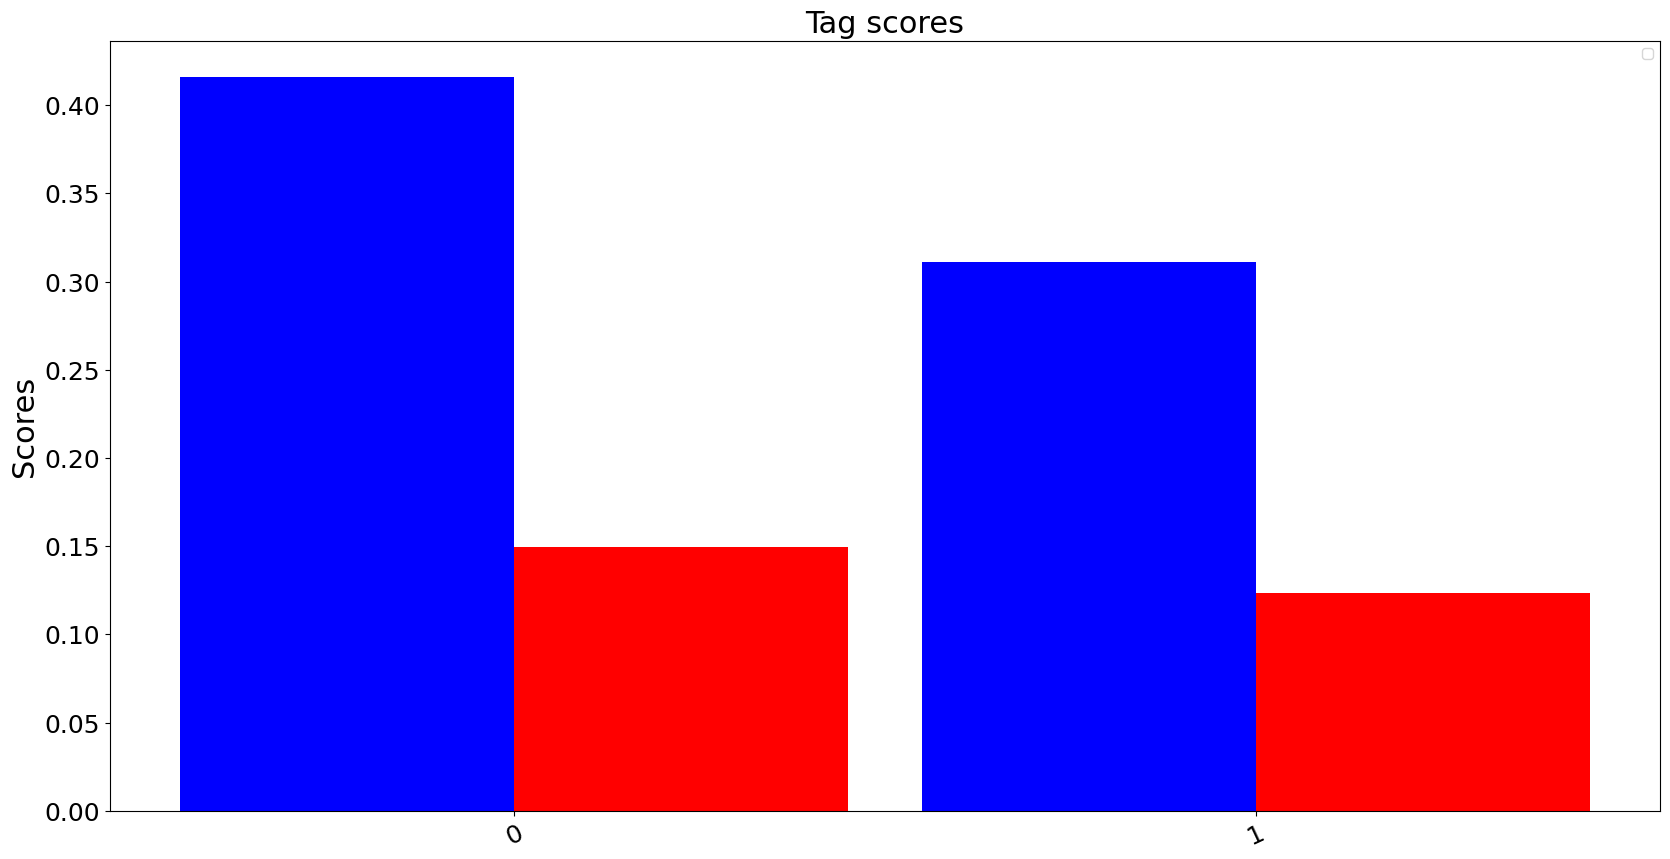

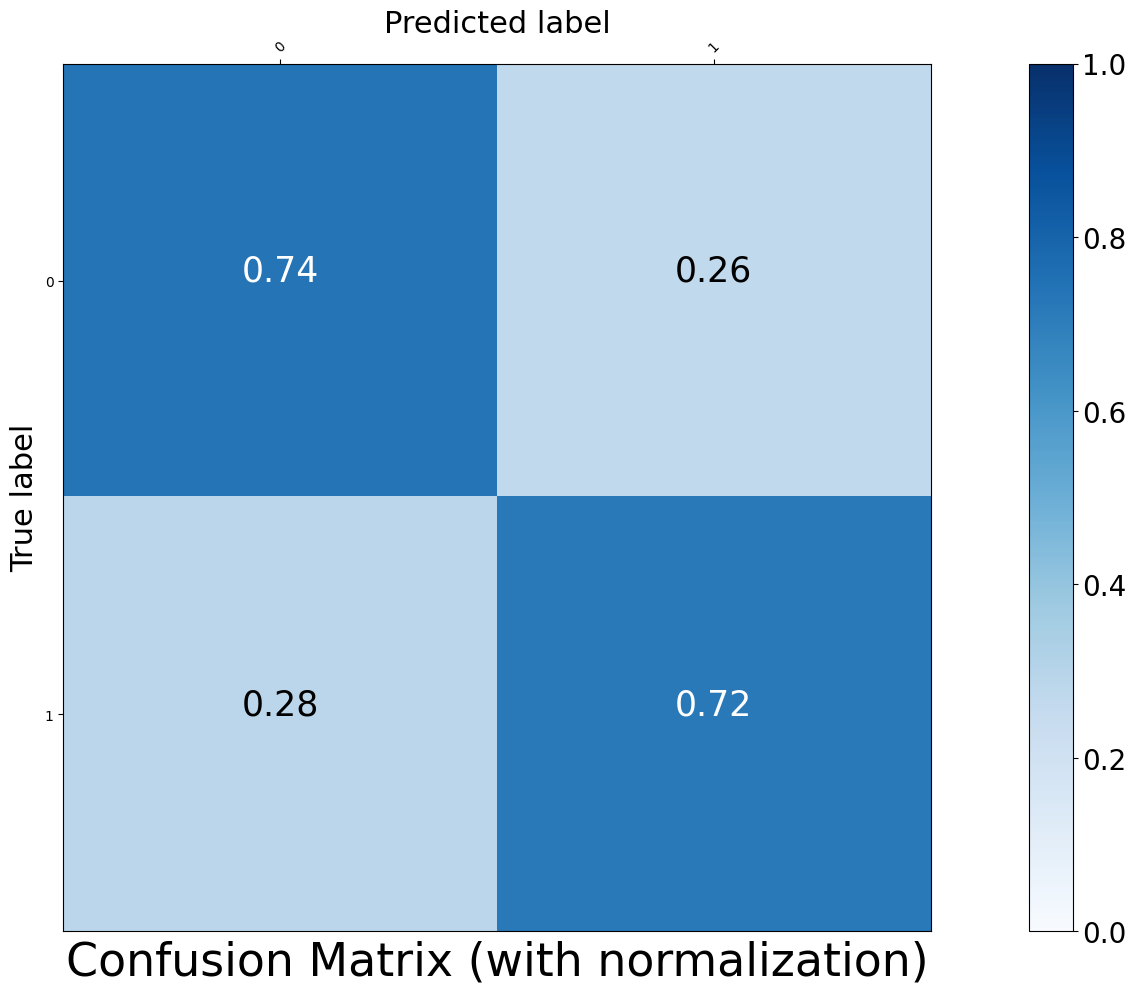

In [14]:
# We save the metrics as png files, for further evaluation/analysis
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(preds, axis=1)
class_names, report, support = get_report(y_true, y_pred, classes)
cm = confusion_matrix(y_true, y_pred, labels=classes)
scores = get_scores(y_true, y_pred, classes)

plot_tag_scores(classes, scores, filename=filename+'_tag_scores')
plot_confusion_matrix(classes, cm, filename=filename+'_cm')

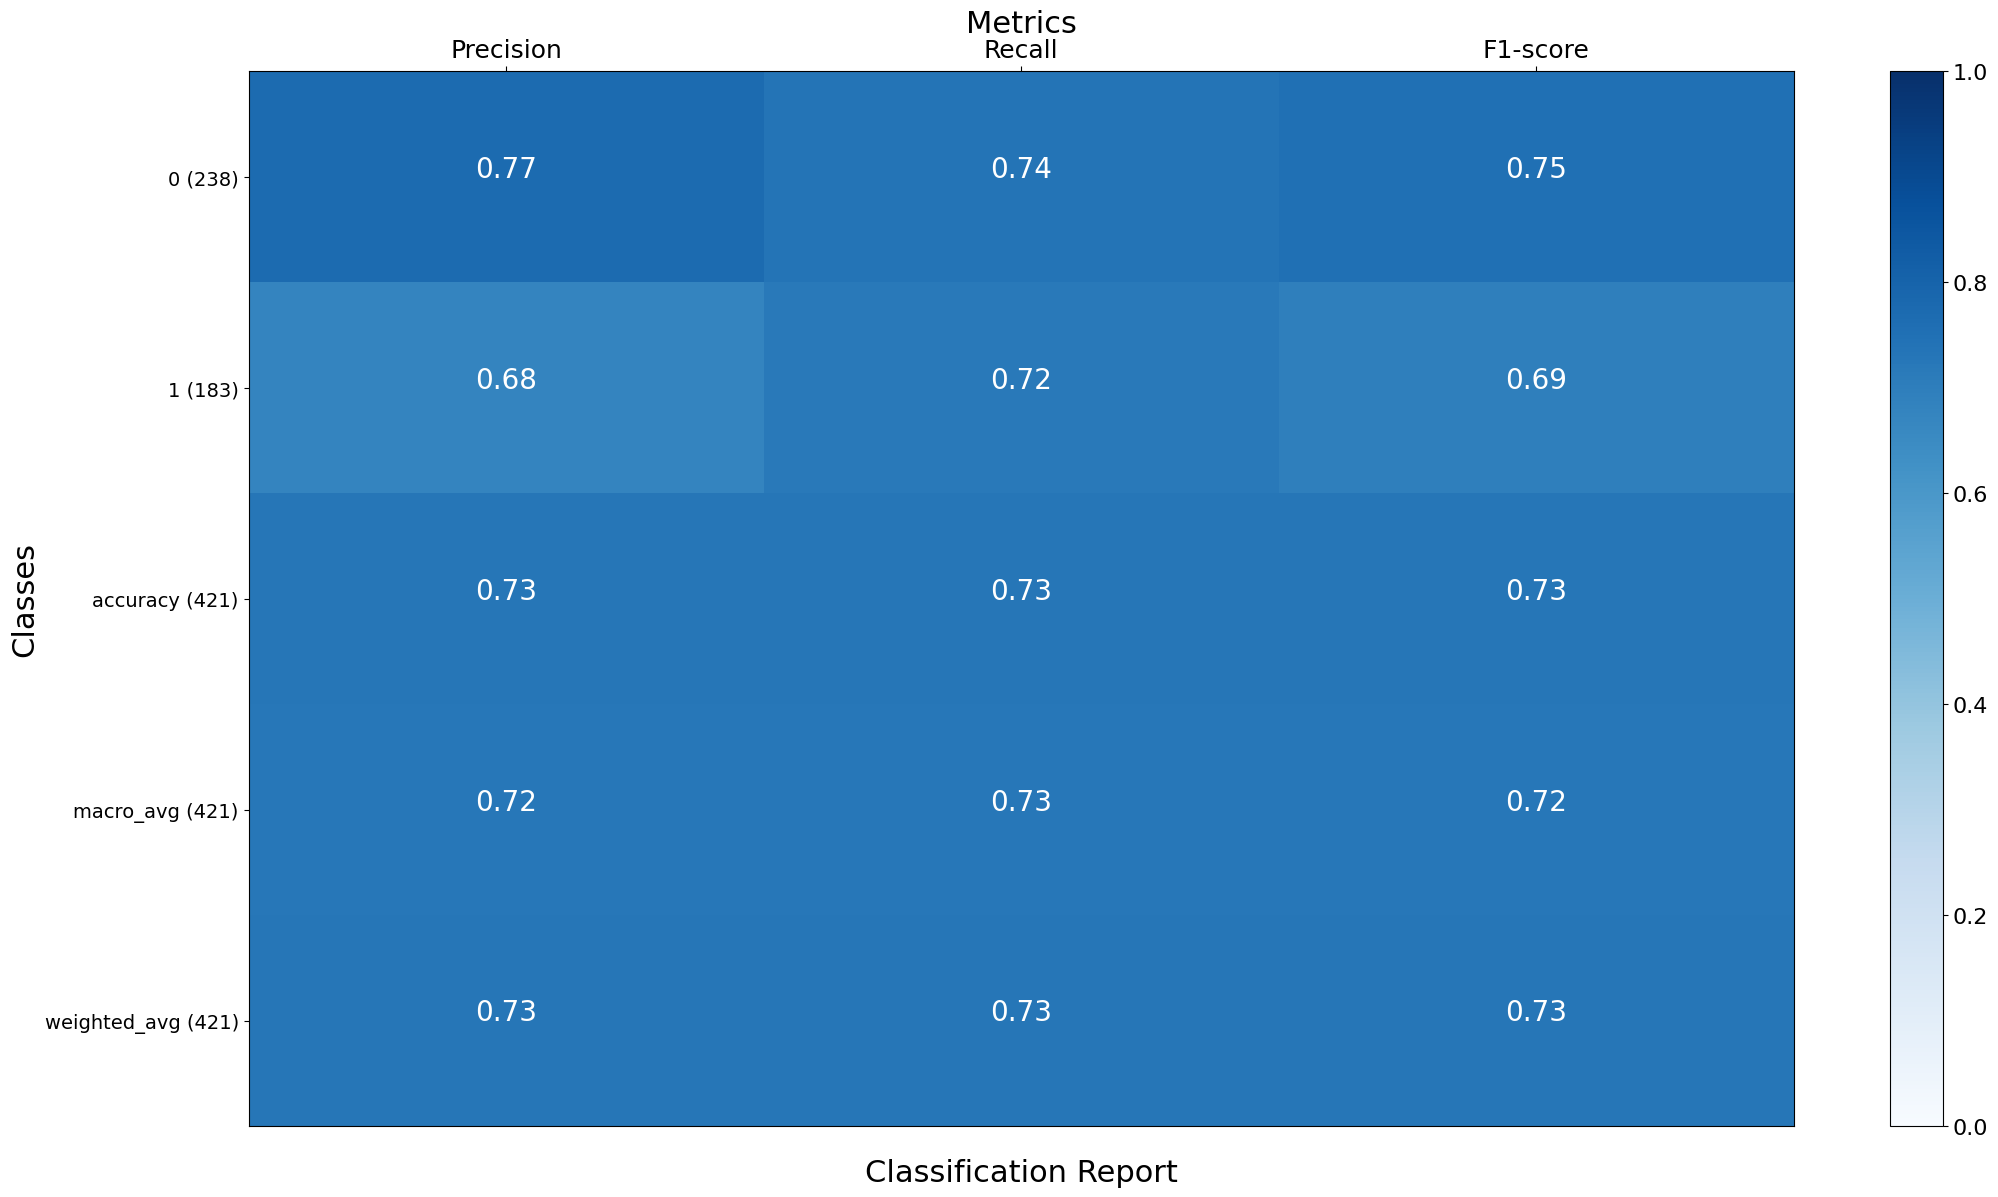

In [15]:
plot_clf_report(class_names, report, support, filename=filename+'_clf_report')

In [16]:
!zip -r results.zip *.png

  adding: mosi_50_seq_TAV_2way_memsz512_clf_report.png (deflated 19%)
  adding: mosi_50_seq_TAV_2way_memsz512_cm.png (deflated 14%)
  adding: mosi_50_seq_TAV_2way_memsz512_tag_scores.png (deflated 30%)


In [17]:
import pickle

In [18]:
filename = 'multimodal_model.h5'
pickle.dump(model_name, open(filename, 'wb'))